In [7]:
import pandas as pd

# Load the data
df = pd.read_csv('PedInf.txt', delimiter='\t')

# Create edge list
edges = []
for _, row in df.iterrows():
    if pd.notna(row['MaleParent']):
        edges.append((row['MaleParent'], row['LineName']))
    if pd.notna(row['FemaleParent']):
        edges.append((row['FemaleParent'], row['LineName']))

edges_df = pd.DataFrame(edges, columns=["Parent", "Child"])

# Save edges to CSV for loading into cuGraph
edges_df.to_csv("edges.csv", index=False)


In [19]:
import cudf
import cugraph

# Load the edges into cuDF
edges_df = cudf.read_csv("edges.csv")

# Create an undirected graph directly
G = cugraph.Graph(directed=False)
G.from_cudf_edgelist(edges_df, source='Parent', destination='Child')

# Perform Louvain community detection
louvain_parts, modularity = cugraph.louvain(G)
louvain_parts = louvain_parts.to_pandas()

# Display the results
print("Louvain Community Detection")
print(louvain_parts.head(10))


/home/useradd/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/cugraph/structure/symmetrize.py:93: FutureWarning: Multi is deprecated and the removal of multi edges will no longer be supported from 'symmetrize'. Multi edges will be removed upon creation of graph instance.
  warnings.warn(


Louvain Community Detection
   partition      vertex
0         27   CP95-1987
1          4   CP06-2707
2          3   CP69-0391
3          6   CP13-1137
4          6   CP10-1246
5         25   CP17-1729
6         26   CP07-1183
7         17   CP91-1034
8          3  LCP85-0322
9          9   CP12-1176


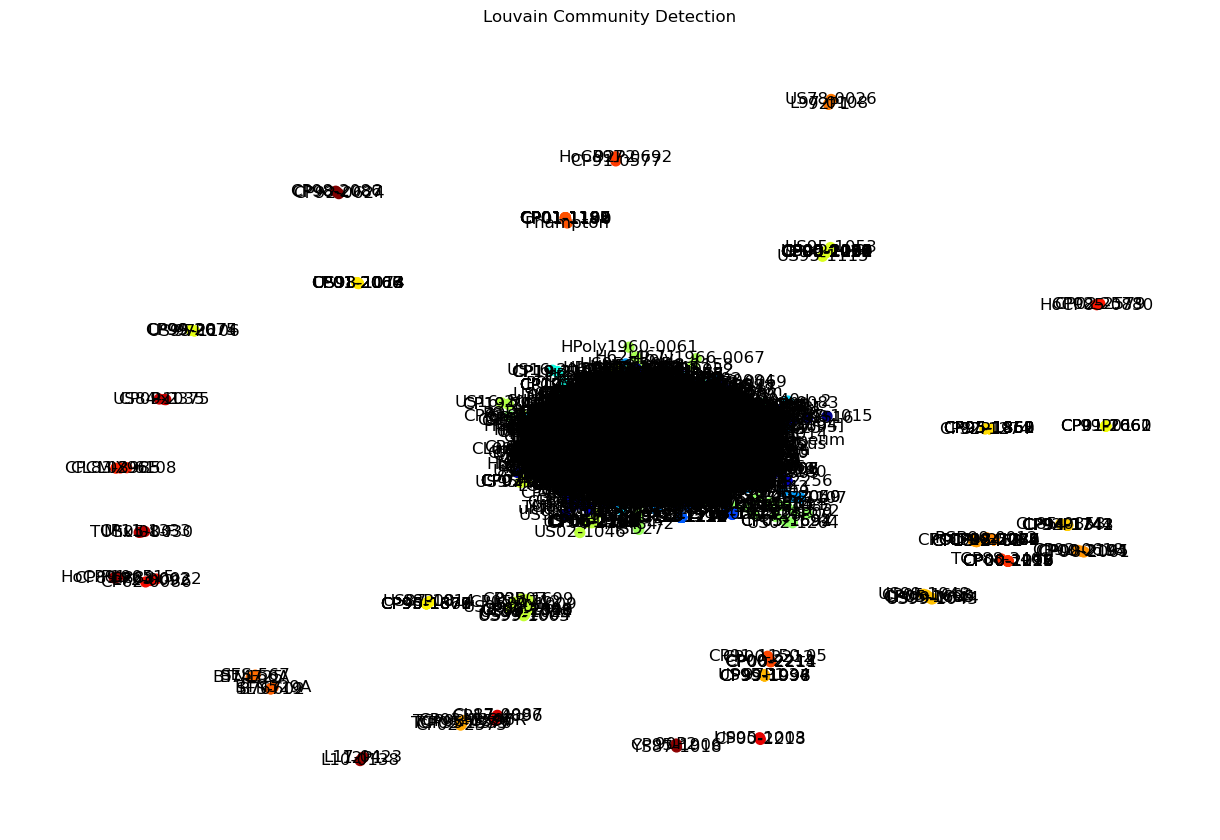

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert cuGraph edges to a pandas DataFrame
edges_df = G.view_edge_list().to_pandas()

# Create a NetworkX graph from the edge list
G_nx = nx.from_pandas_edgelist(edges_df, source='Parent', target='Child')

# Add Louvain community information to the NetworkX graph
louvain_communities = louvain_parts.set_index('vertex')['partition'].to_dict()
nx.set_node_attributes(G_nx, louvain_communities, 'louvain')

# Plot Louvain communities
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_nx)
colors = [louvain_communities.get(node, 0) for node in G_nx.nodes()]
nx.draw(G_nx, pos, node_color=colors, with_labels=True, node_size=50, cmap=plt.cm.jet)
plt.title('Louvain Community Detection')
plt.show()


In [21]:
# Convert cuGraph edges to a pandas DataFrame
edges_df = G.view_edge_list().to_pandas()

# Print the columns to verify
print(edges_df.columns)

Index(['Parent', 'Child'], dtype='object')
